In [37]:
import requests
from bs4 import BeautifulSoup as bs4
import re
import pandas as pd
import time

In [77]:
def get_article_voice(forum_url, page=1):
    """爬取文章列表"""
    HEADERS = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'}   
    my_params = {'page':page}
    page_list = []
    r = requests.get(forum_url, headers = HEADERS, params = my_params)
    article_voices = []
    soup = bs4(r.text, features = 'lxml')
    item_blocks = soup.select('table.b-list tr.b-list-item')
    for item_block in item_blocks:
        title_block = item_block.select_one('.b-list__main__title')
        response_block = item_block.select_one('.b-list__count__number')
        time_block = item_block.select_one('.b-list__time .b-list__time__edittime')
        
        article_url = f"https://forum.gamer.com.tw/{title_block.get('href')}"
        
        title = title_block.text
        response = response_block.select_one('span:nth-child(1)').get('title')
        voice = response_block.select_one('span:nth-child(2)').get('title')
        time_ = time_block.text
        time_ = re.sub('\n',"",time_)

        if response != None:
            response = re.findall(r'[\d,]+',response)
        if voice != None:
            voice = re.findall(r'[\d,]+',voice)
        
        dict = {'title':title, 'response':response, 'voice':voice, 'time':time_}
        page_list.append(dict)
    df = pd.DataFrame(page_list)
    df = df.explode('response').explode('voice')
    df = df.replace(regex={'今日':'1/27'}).replace(regex={'昨日':'1/26'})
    
    time.sleep(0.5)
    
    return(df)


In [12]:
# forum_url = "https://forum.gamer.com.tw/B.php?bsn=30518"
# df2 = get_article_voice(forum_url,2)

In [110]:
# d = {}
# for i in range(1, 10):
#     d["df{0}".format(i)] = "Hello"
# d

In [111]:
#%%timeit this would loops many times
forum_url = "https://forum.gamer.com.tw/B.php?bsn=30518"

total_post = pd.DataFrame()

for p in range(1,38):
    df = get_article_voice(forum_url,p)
    total_post = total_post.append(df, ignore_index=True)
total_post

,title,response,voice,time
0,【專區】板務建議、問題回報、精華區專區,0,0,1/27 13:46
1,【集中】集中串及推薦連結傳送門,1,"66,133",07/04 20:04
2,【討論】求求你別送頭 │ 雷雷隊友抱怨討論區,1,63,1/27 21:18
3,【討論】英雄的萬事屋 │ 新老手兩行簡短發問討論區,8,135,1/27 16:52
4,【集中】傳說戰友集結 │ 各式活動序號分享區,1,68,1/27 18:11
...,...,...,...,...
1105,【討論】克里希的魔法轉盤,79,"17,128",10/02 22:26
1106,【問題】沒有不合適的環境？,12,"3,764",10/02 21:36
1107,【討論】泰國的造型設計大賽-已選出冠軍,28,"9,975",10/02 18:51
1108,首篇已刪,67,"5,311",10/02 14:30


In [112]:
total_post.to_csv (r'D:\data science\side projects\AoV\data\voice_data.csv', index = False, header=True)

In [155]:
total_post = pd.read_csv(r'D:\data science\side projects\AoV\data\voice_data.csv')

In [123]:
total_post = total_post[9:] #去除至頂文章

In [124]:
total_post = total_post.reset_index().iloc[:,1:]

In [116]:
total_post.dtypes

title       object
response    object
voice       object
time        object
dtype: object

In [125]:
pd.to_datetime(total_post.head(5)['time'], format = '%m/%d %H:%M').apply(lambda x: x.replace(year = 2021))

0   2021-01-27 22:10:00
1   2021-01-27 22:09:00
2   2021-01-27 21:06:00
3   2021-01-27 20:26:00
4   2021-01-27 19:42:00
Name: time, dtype: datetime64[ns]

In [126]:
total_post['time'] = pd.to_datetime(total_post['time'], format = '%m/%d %H:%M')

In [128]:
total_post[total_post['time'].dt.month==1]['time']

0     1900-01-27 22:10:00
1     1900-01-27 22:09:00
2     1900-01-27 21:06:00
3     1900-01-27 20:26:00
4     1900-01-27 19:42:00
              ...        
312   1900-01-01 10:19:00
313   1900-01-01 06:29:00
314   1900-01-01 03:06:00
315   1900-01-01 00:27:00
316   1900-01-01 00:10:00
Name: time, Length: 317, dtype: datetime64[ns]

In [139]:
total_post.iloc[:316].loc['time'] = total_post[:316]['time'].apply(lambda x: x.replace(year = 2021))
total_post.iloc[316:].loc['time'] = total_post[316:]['time'].apply(lambda x: x.replace(year = 2020))

C:\Users\aoc32\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [146]:
total_post['voice'] = pd.to_numeric(total_post['voice'].apply(lambda x:x.replace(',','')))
total_post['response'] = pd.to_numeric(total_post['response'].apply(lambda x:x.replace(',','')))

In [147]:
total_post.dtypes

title               object
response             int64
voice                int64
time        datetime64[ns]
dtype: object

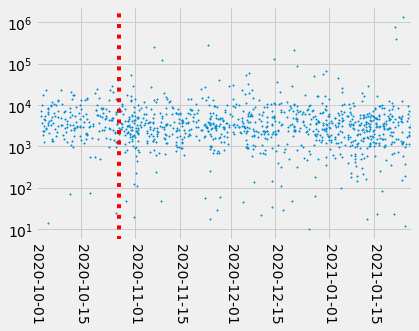

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
%matplotlib inline
plt.style.use("fivethirtyeight")

plt.scatter(total_post['time'], total_post['voice'], s=2)
plt.xlim(pd.Timestamp('2020-10-01'), pd.Timestamp('2021-01-27'))
plt.yscale('log')
plt.xticks(rotation=270)
plt.axvline(x=pd.Timestamp('2020-10-27'), linestyle=':', color = 'red');

In [ ]:
fig = plt.figure()
plt.scatter(total_post['time'], total_post['response'], s=2)
plt.xlim(pd.Timestamp('2020-10-01'), pd.Timestamp('2021-01-27'))
plt.ylim(-50,200)
plt.xticks(rotation=270);

In [174]:
#RDD design
df = total_post[total_post.copy()['response']<=200]
rdd_df = df.assign(threshold=(df['time']>=pd.Timestamp('2020-10-27')).astype(int))
rdd_df

,title,response,voice,time,threshold
0,【情報】01 / 28（四）伺服器不停機臨時更新公告,10,410,2021-01-27 22:10:00,1
2,【問題】刀鋒到底要下去了沒,19,2877,2021-01-27 21:06:00,1
3,"【討論】沒了心態,遊戲也不在好玩",41,2558,2021-01-27 20:26:00,1
5,【心得】這版排位紅方很虧,17,1114,2021-01-27 19:13:00,1
6,【閒聊】有關愛里 說好的等著被打臉呢？,11,1663,2021-01-27 18:58:00,1
...,...,...,...,...,...
1096,【討論】克里希的魔法轉盤,79,17128,2020-10-02 22:26:00,0
1097,【問題】沒有不合適的環境？,12,3764,2020-10-02 21:36:00,0
1098,【討論】泰國的造型設計大賽-已選出冠軍,28,9975,2020-10-02 18:51:00,0
1099,首篇已刪,67,5311,2020-10-02 14:30:00,0


In [182]:
rdd_df['time'] = (rdd_df.copy()['time']-pd.Timestamp('2020-10-27'))/pd.offsets.Day()

In [183]:
model = smf.wls("response~time*threshold", rdd_df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,23.8764,2.047,11.662,0.000,19.859,27.894
time,0.0325,0.077,0.423,0.673,-0.118,0.183
threshold,-5.6239,2.570,-2.189,0.029,-10.666,-0.582
time:threshold,0.0198,0.082,0.243,0.808,-0.140,0.180


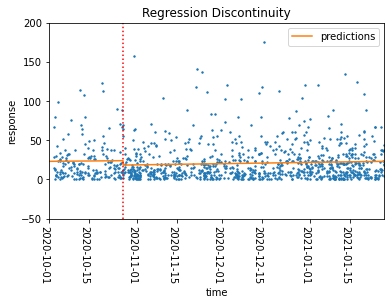

In [195]:
ax = df.plot.scatter(x="time", y="response", color="C0", s=2)
df.assign(predictions=model.fittedvalues).plot(x="time", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity")
plt.xlim(pd.Timestamp('2020-10-01'), pd.Timestamp('2021-01-27'))
plt.ylim(-50,200)
plt.xticks(rotation=270)
plt.axvline(x=pd.Timestamp('2020-10-27'), linestyle=':', color = 'red');

從圖形中我們可以看到voice在threshold前後並無顯著斷點。
而response的話，從回歸結果中，我們可以看到time:threshold的p-value極高，代表兩條回歸線並無顯著差距。